In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/HistoricalQuotes.csv')

# Remove leading or trailing whitespace from column names
data.columns = data.columns.str.strip()

# Remove the dollar sign ('$') and convert to numeric
data['Close/Last'] = data['Close/Last'].replace({'\$': '', ',': ''}, regex=True)
data['Close'] = pd.to_numeric(data['Close/Last'], errors='coerce')

# Drop rows with NaN values in 'Close'
data.dropna(subset=['Close'], inplace=True)

# Check if data is empty after cleaning
if not data.empty:
    # Keep only the 'Close' column
    data = data[['Close']]

    # Normalize data using Min-Max Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    # Split data into training and testing sets (80% training, 20% testing)
    train_size = int(len(data_scaled) * 0.8)
    train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

    # Confirm successful preprocessing
    print("Data preprocessing complete. Training and testing sets prepared.")
else:
    print("Error: DataFrame is empty after cleaning. Check the CSV file or conversion process.")


Data preprocessing complete. Training and testing sets prepared.


In [15]:
def create_sequences(data, sequence_length=60):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

sequence_length = 60
x_train, y_train = create_sequences(train_data, sequence_length)
x_test, y_test = create_sequences(test_data, sequence_length)

# Reshape for RNN input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(x_train.shape[1], 1), return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0228 - val_loss: 2.3402e-04
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.4779e-04 - val_loss: 1.9020e-04
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0582e-04 - val_loss: 7.2563e-05
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2702e-04 - val_loss: 6.3433e-05
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6307e-04 - val_loss: 1.1201e-04
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6136e-04 - val_loss: 5.6937e-05
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9751e-04 - val_loss: 3.8609e-05
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1429e-04 - val_loss: 7.2016e-05
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9730e-04 - val_loss: 6.2465e-05
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6318e-04 - val_loss: 3.5161e-05
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7433e-04 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


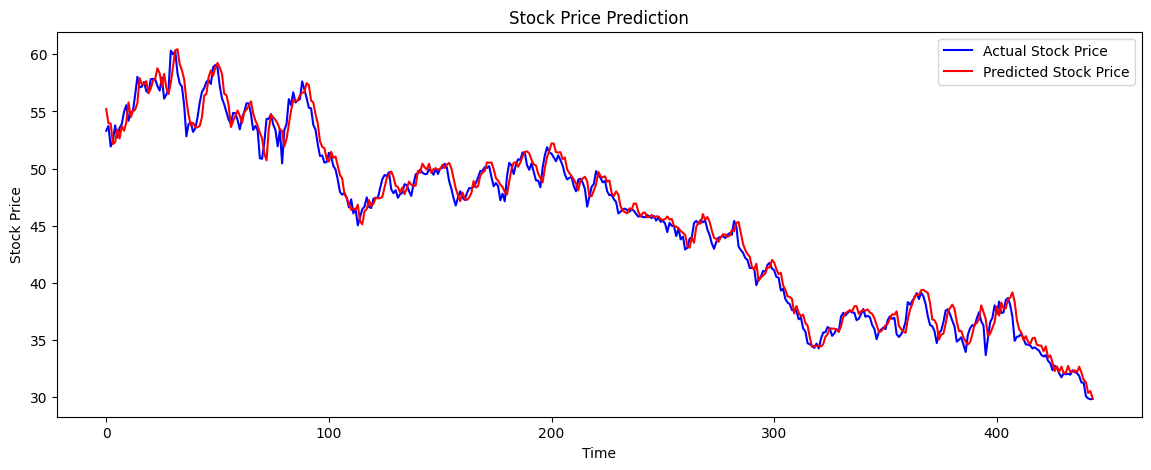

In [18]:
# Make predictions
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)  # Convert back to original scale

# Convert test data back to original scale for comparison
y_test = scaler.inverse_transform([y_test])

# Plot the predicted vs. actual stock prices
plt.figure(figsize=(14,5))
plt.plot(y_test[0], color='blue', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test[0], predicted_prices)
rmse = np.sqrt(mean_squared_error(y_test[0], predicted_prices))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')


Mean Absolute Error: 0.7329211939837482
Root Mean Squared Error: 0.9609202186488014
